## Load Library

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
os.chdir('/content/drive/MyDrive')

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from Cython.Compiler.Naming import args_cname
from tensorboard.compat.tensorflow_stub.dtypes import float32
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, Dict, Any, Optional
from dataclasses import dataclass
import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet34
import torch.optim as optim
import os

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data loading

In [11]:
def load_dataset(file_path, val_ratio=0.2, random_state=42):
    dataset = np.load(file_path)
    Xtr, Str = dataset['Xtr'], dataset['Str']
    Xts, Yts = dataset['Xts'], dataset['Yts']

    # Shuffle & split (80% train, 20% validation)
    np.random.seed(random_state)
    indices = np.arange(len(Str))
    np.random.shuffle(indices)

    split_idx = int(len(Str) * (1 - val_ratio))
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]

    X_train, y_train = Xtr[train_idx], Str[train_idx]
    X_val, y_val = Xtr[val_idx], Str[val_idx]

    return X_train, y_train, X_val, y_val, Xts, Yts

def reshape_mnist(*arrays):
    reshaped = []

    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = arr.reshape(-1, 1, 28, 28)
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            mean = torch.tensor(0.1307, dtype=torch.float32).view(1, 1, 1)
            std  = torch.tensor(0.3081, dtype=torch.float32).view(1, 1, 1)
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)

def reshape_cifar(*arrays):
    reshaped = []
    mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
    std  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = np.transpose(arr, (0, 3, 1, 2))
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)


In [12]:
Xtr_03, Str_03, Xval_03, Sval_03, Xts_03, Yts_03 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.3.npz'))
Xtr_06, Str_06, Xval_06, Sval_06, Xts_06, Yts_06 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.6.npz'))
Xtr_cifar, Str_cifar, Xval_cifar, Sval_cifar, Xts_cifar, Yts_cifar = reshape_cifar(*load_dataset('datasets/CIFAR.npz'))

In [14]:
print("Xtr_03:", Xtr_03.shape)
print("Xtr_06:", Xtr_06.shape)
print("Xtr_cifar:", Xtr_cifar.shape)

Xtr_03: torch.Size([14400, 1, 28, 28])
Xtr_06: torch.Size([14400, 1, 28, 28])
Xtr_cifar: torch.Size([12000, 3, 32, 32])


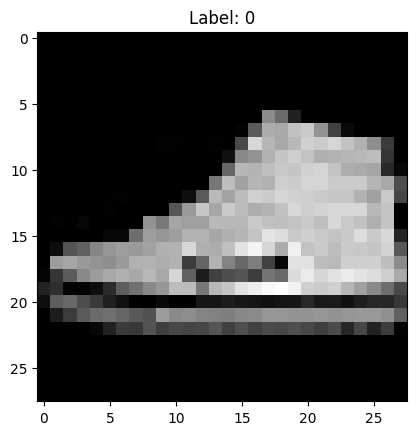

In [15]:
# Mnist data checking
plt.imshow(Xtr_03[114, -1, :, :], cmap='gray') #[pic number,_,_,_]
plt.title(f"Label: {Str_03[0]}")
plt.show()

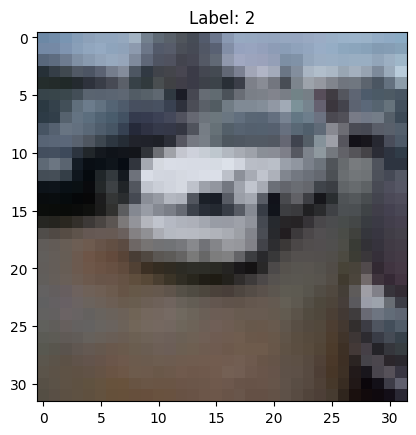

In [25]:
# CIFAR data checking
mean_test = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
std_test  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
test_cifar = Xtr_cifar[514] * std_test + mean_test
plt.imshow(np.transpose(test_cifar, (1, -1, 0)))
plt.title(f"Label: {Str_cifar[0]}")
plt.show()

# Main Program

## Classifier: ResNet-34

In [26]:
# ---------------------------
# Config
# ---------------------------
@dataclass
class Cfg:
    num_classes: int = 3
    epochs: int = 60
    batch_size: int = 128
    lr: float = 0.01
    momentum: float = 0.9
    weight_decay: float = 1e-4
    milestones: Tuple[int, int] = (30, 60)
    lam: float = 0.3                 # weight for cycle term
    n_epoch: int = 60
    warmup_epoch: int = 10
    anchor: bool = False
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes,mode='cifar10'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        if mode == 'mnist':
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=False)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, revision=True):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)

        out = self.linear(out)

        clean = F.softmax(out, 1)

        return clean

def ResNet34(num_classes):
  return ResNet(BasicBlock, [3,4,6,3], num_classes)

In [28]:
# ---------------------------
# transition matrix
# ---------------------------
class sig_t(nn.Module):
    def __init__(self, device, num_classes, init=2):
        super(sig_t, self).__init__()

        self.register_parameter('w', nn.Parameter(-init*torch.ones(3, 3, device=device)))

        self.w.to(device)

        co = torch.ones(num_classes, num_classes)
        ind = np.diag_indices(co.shape[0])
        co[ind[0], ind[1]] = torch.zeros(co.shape[0])
        self.co = co.to(device)
        self.identity = torch.eye(num_classes).to(device)


    def forward(self):
        sig = torch.sigmoid(self.w)
        T = self.identity.detach() + sig * self.co.detach()
        T = F.normalize(T, p=1, dim=1)
        return T


In [ ]:
def warmup(train_data, train_loader, model,optimizer_model, loss_func_ce):

    model.train()
    train_loss = 0.

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer_model.zero_grad()

        clean = model(batch_x)

        ce_loss = loss_func_ce(clean.log(), batch_y.long())
        res = torch.mean(torch.sum(clean.log() * clean, dim=1))
        loss = ce_loss + res

        train_loss += loss.item()

        loss.backward()
        optimizer_model.step()


    print('Warmup Loss: {:.6f}'.format(train_loss / (len(train_data))*Cfg.batch_size))


def train(train_data, train_loader,model,trans_for,trans_back,optimizer_es,optimizer_trans_for,optimizer_trans_back,scheduler1,scheduler2,scheduler3,loss_func_ce, Cfg):
    model.train()
    trans_for.train()
    trans_back.train()

    train_loss = 0.
    train_acc = 0.

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = torch.zeros(batch_x.size(0), Cfg.num_classes).scatter_(1, batch_y.view(-1,1), 1)
        batch_y = batch_y.to(device)

        clean = model(batch_x)
        noise = F.softmax(batch_y, 1)

        t_for = trans_for()
        t_back = trans_back()

        out = torch.mm(clean, t_for)
        out1 = torch.mm(noise, t_back)

        noise_y = torch.max(noise, dim=1)[1].detach()
        clean_y = torch.max(clean, dim=1)[1].detach()
        ce_loss = loss_func_ce(out.log(), noise_y.long())
        ce_loss_1 =  loss_func_ce(out1.log(), clean_y.long())

        for_back_1 = torch.mm(clean, t_for.detach())
        for_back = torch.mm(for_back_1, t_back.detach())

        loss_for_back = loss_func_ce(for_back.log(), clean_y.long())  #loss_func_ce(for_back.log(), clean_y.long()) #-torch.mean(torch.sum(for_back.log() * clean,dim=1)) #


        loss = ce_loss  + ce_loss_1+ Cfg.lam * loss_for_back

        train_loss += loss.item()

        pred = torch.max(out, 1)[1]
        train_correct = (pred == noise_y).sum()
        train_acc += train_correct.item()

        optimizer_es.zero_grad()
        optimizer_trans_for.zero_grad()
        optimizer_trans_back.zero_grad()

        loss.backward()

        optimizer_es.step()
        optimizer_trans_for.step()
        optimizer_trans_back.step()

    print('Train Loss: {:.6f},  Acc: {:.6f}'.format(train_loss / (len(train_data))*Cfg.batch_size,  train_acc / (len(train_data))))

    scheduler1.step()
    scheduler2.step()
    scheduler3.step()


def val(val_data, val_loader, model, trans, loss_func_ce):
    val_acc = 0.
    val_loss = 0.

    with torch.no_grad():
        model.eval()
        trans.eval()

        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            clean = model(batch_x)
            t = trans()

            out = torch.mm(clean, t)
            loss = loss_func_ce(out.log(), batch_y.long())
            val_loss += loss.item()
            pred = torch.max(out, 1)[1]
            val_correct = (pred == batch_y).sum()
            val_acc += val_correct.item()


    print('Val Loss: {:.6f}, Acc: {:.6f}'.format(val_loss / (len(val_data))*Cfg.batch_size, val_acc / (len(val_data))))

def test(test_data, test_loader, model, loss_func_ce):
    eval_loss = 0.
    eval_acc = 0.

    with torch.no_grad():
        model.eval()

        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            clean = model(batch_x)

            loss = loss_func_ce(clean.log(), batch_y.long())
            eval_loss += loss.item()
            pred = torch.max(clean, 1)[1]
            eval_correct = (pred == batch_y).sum()
            eval_acc += eval_correct.item()

        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(test_data)) * Cfg.batch_size,
                                                      eval_acc / (len(test_data))))
    return eval_acc / (len(test_data))


In [ ]:
def main(dataset_name):
    #init
    print(Cfg)

    criterion = torch.nn.NLLLoss(reduction="mean")
    model = ResNet34(Cfg.num_classes)
    milestones = Cfg.milestones

    if dataset_name.lower() in ("mnist03"):
        Xtr, ytr, Xva, yva, Xte, yte = reshape_mnist(*load_dataset("datasets/FashionMNIST0.3.npz"))
    elif dataset_name.lower() in ("mnist06"):
        Xtr, ytr, Xva, yva, Xte, yte = reshape_mnist(*load_dataset("datasets/FashionMNIST0.6.npz")
    elif dataset_name.lower() in ("cifar"):
        Xtr, ytr, Xva, yva, Xte, yte = reshape_cifar(*load_dataset("datasets/CIFAR.npz"))
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    train_data = TensorDataset(Xtr, ytr)
    val_data = TensorDataset(Xva, yva)
    test_data = TensorDataset(Xte, yte)

    trans = sig_t(device, Cfg.num_classes)
    trans_1 = sig_t(device, Cfg.num_classes)
    optimizer_trans = optim.SGD(trans.parameters(), lr=Cfg.lr, weight_decay=0, momentum=0.9)
    optimizer_trans_1 = optim.SGD(trans_1.parameters(), lr=Cfg.lr, weight_decay=0, momentum=0.9)


    #optimizer and StepLR
    optimizer_es = optim.SGD(model.parameters(), lr=Cfg.lr, weight_decay=Cfg.weight_decay, momentum=0.9)
    scheduler1 = MultiStepLR(optimizer_es, milestones=milestones, gamma=0.1)
    scheduler2 = MultiStepLR(optimizer_trans, milestones=milestones, gamma=0.1)
    scheduler3 = MultiStepLR(optimizer_trans_1, milestones=milestones, gamma=0.1)


    #data_loader
    train_loader = DataLoader(dataset=train_data,
                              batch_size=Cfg.batch_size,
                              shuffle=True,
                              num_workers=4,
                              drop_last=False)

    val_loader = DataLoader(dataset=val_data,
                            batch_size=Cfg.batch_size,
                            shuffle=False,
                            num_workers=4,
                            drop_last=False)

    test_loader = DataLoader(dataset=test_data,
                             batch_size=Cfg.batch_size,
                             num_workers=4,
                             drop_last=False)

    #cuda
    if torch.cuda.is_available:
        model = model.to(device)
        trans = trans.to(device)
        trans_1 = trans_1.to(device)

    best_acc = 0
    best_acc_back = 0
    #warmup
    for epoch in range(Cfg.warmup_epoch):
        print('epoch[{}], Warmup'.format(epoch + 1))
        warmup(train_data, train_loader, model,optimizer_es, scheduler1,criterion)
        val(val_data, val_loader, model, trans,criterion)
        acc = test(test_data, test_loader, model,criterion)
        if acc> best_acc:
            best_acc = acc
        print('Best_acc: {:.6f}'.format(best_acc))

    acc_list = []
    for epoch in range(Cfg.n_epoch):
        print('epoch[{}], Train'.format(epoch+1))
        train(train_data,train_loader,model,trans,trans_1,optimizer_es,optimizer_trans,optimizer_trans_1,scheduler1,scheduler2,scheduler3,criterion)
        val(val_data, val_loader, model, trans,criterion)
        acc = test(test_data, test_loader, model,criterion)

        acc_list.append(acc)

        if acc> best_acc:
            best_acc = acc


        print('Best_acc: {:.6f}'.format(best_acc))


    print('Best_acc: ', best_acc)
    return best_acc,acc_list


# Running

In [ ]:
cfg = Cfg(num_classes=10, epochs=60, batch_size=128, lr=1e-2,
          milestones=(30,60), lam=0.3,
          device="cuda" if torch.cuda.is_available() else "cpu")

best = main(cfg, dataset_name="mnist")   # 或 "cifar10"
print("Best Acc =", best)


✅ Test (MNIST0.3) complete.
Best Test Accuracy @ Val = 97.92%

Forward T (shape: (3, 3) ) first 3 cols:
 [[0.756  0.2297 0.0143]
 [0.0205 0.9129 0.0666]
 [0.0375 0.0191 0.9434]]

Backward T' (shape: (3, 3) ) first 3 cols:
 [[0.9424 0.0164 0.0412]
 [0.3008 0.6749 0.0243]
 [0.0288 0.0546 0.9166]]


In [ ]:
T_est